<a href="https://colab.research.google.com/github/BenxiaHu/DeepLearning/blob/main/pytorch_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network


Dependencies:
* torch: 0.1.11
* matplotlib

# step0: import python packages

In [49]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
from numpy import array
import pandas as pd
import numpy as np
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import requests
torch.manual_seed(1)



# step1: import data

In [54]:
seqid="https://raw.githubusercontent.com/BenxiaHu/DeepLearning/main/sequences.txt"
labelid="https://raw.githubusercontent.com/BenxiaHu/DeepLearning/main/labels.txt"
input = pd.read_csv(seqid,header=None)
label = pd.read_table(labelid,header=None)


# Convert input to one-hot code
#def one_hot_encoding(seq):
#    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
#    one_hot = [mapping[nuc] for nuc in seq]
#    return np.array(one_hot)

#one_hot_input = np.array([one_hot_encoding(seq) for seq in input[0]])
#
#one_hot_input = torch.from_numpy(one_hot_input)
#one_hot_input = one_hot_input.permute(0, 2, 1)
#print(one_hot_input.shape)

# Split the data into training, test, and prediction sets
# Split the data into training, testing, and prediction sets
#x_train, x_test, y_train, y_test = train_test_split(one_hot_input, label, test_size=0.3, random_state=42)
#x_test, x_pred, y_test, y_pred = train_test_split(x_test, y_test, test_size=0.67, random_state=42)
#print(x_train.shape)
#print(x_test.shape)


DNA = np.zeros(shape=(len(input),len(input[0][0]),4))
labelid = np.zeros(shape=(len(input),))
#print(DNA.shape)
#print(labelid.shape)

for i in range(input.shape[0]):
    seq_array = array(list(input[0][i]))
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse_output=False)
    #reshape because that's what OneHotEncoder likes
    #print(integer_encoded_seq.shape)
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    #print(integer_encoded_seq.shape)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    #print(onehot_encoded_seq.shape)
    #print(len(onehot_encoded_seq))
    DNA[i] = onehot_encoded_seq
    #DNA[i] = onehot_encoded_seq.reshape(4,len(onehot_encoded_seq))
    labelid[i] = label[0][i]

#print(DNA.shape)
#print(labelid.shape)

DNA = torch.tensor(DNA)
DNA = DNA.permute(0, 2, 1)
labelid =  torch.tensor(labelid)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    DNA = DNA.to("cuda:0")
    labelid =  labelid.to("cuda:0")
#print(DNA.is_cuda)

#print(np.shape(DNA))
#embed_x = embed_x.permute(0, 2, 1)

# step2: split the data into training, test and prediction data

In [59]:
#input_tensor = DNA
#label_tensor = labelid
# pick 1400 samples as training data
#print(input_tensor[0:1400,:,:].shape)
#print(label_tensor[0:1400].shape)

# Split the data into training, test, and prediction sets
x_train, x_test, y_train, y_test = train_test_split(DNA, labelid, test_size=0.3, random_state=42)

#print(x_train.shape)
# Hyper Parameters
EPOCH = 10000              # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 100
LR = 0.01                 # learning rate
torch_dataset = Data.TensorDataset(x_train, y_train)
train_loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)
torch_dataset2 = Data.TensorDataset(x_test, y_test)
test_loader = Data.DataLoader(dataset=torch_dataset2, shuffle=True)
              
# Data Loader for easy mini-batch return in training, the image batch shape will be (100, 1, 50, 4)

#for i, j in enumerate(train_loader):
    #x, y = j
    #print('batch:{0} x:{1}  y: {2}'.format(i, x, y))
    #print(i)
    #print(x.shape)
    #print(y.shape)

# pick 400 samples as prediction data
#test_x2 = Variable(input_tensor[1600:2000,:,:]).type(torch.FloatTensor)
#test_y2 = label_tensor[1600:2000]


# step4: build the 1D-CNN model

In [60]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (50,4,50)
            nn.Conv1d(
                in_channels=4,              # input height
                out_channels=32,            # n_filters
                kernel_size=11,             # filter size
                stride=1,                   # filter movement/step
                padding=0                   # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (32, 1, 40)
            nn.ReLU(),                      # activation
            nn.MaxPool1d(
                kernel_size=3,
                stride=1,
                padding=0)                  # choose max value in 1x2 area, output shape (32, 1, 38)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 1, 38)
            nn.Conv1d(
                in_channels=32,             # input height
                out_channels=16,            # n_filters
                kernel_size=11,             # filter size
                stride=1,                   # filter movement/step
                padding=0                   # output shape (16, 1, 28)
            ),
            nn.ReLU(),                      # activation
            nn.MaxPool1d(
                kernel_size=3,
                stride=1,
                padding=0)                # output shape (16, 1, 26)
        )
        self.conv3 = nn.Sequential(       # input shape (16, 1, 26)
            nn.Conv1d(
                in_channels=16,           # input height
                out_channels=8,           # n_filters
                kernel_size=11,           # filter size
                stride=1,                 # filter movement/step
                padding=0                 # output shape (8, 1, 16)
            ),
            nn.ReLU(),                    # activation
            nn.MaxPool1d(
                kernel_size=3,
                stride=1,
                padding=0)                # output shape (8, 1, 14)
        )
        self.conv4 = nn.Sequential(       # input shape (8, 1, 14)
            nn.Conv1d(
                in_channels=8,            # input height
                out_channels=4,           # n_filters
                kernel_size=11,           # filter size
                stride=1,                 # filter movement/step
                padding=0                 # output shape (4, 1, 6)
            ),
            nn.ReLU(),                    # activation
            nn.MaxPool1d(
                kernel_size=3,
                stride=1,
                padding=0)                # output shape (4, 1, 2)
        )
        #self.relu = nn.ReLU()
        self.fc1 = nn.Linear(112, 10)     # fully connected layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 2)       # fully connected layer

    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())            # torch.Size([50, 32, 38])
        x = self.conv2(x)
        #print(x.size())            # torch.Size([50, 16, 26])
        x = self.conv3(x)
        #print(x.size())            # torch.Size([50, 8, 14])
        #x = self.conv4(x)
        #print(x.size())            # torch.Size([50, 4, 2])
        x = x.view(x.size(0), -1)   # flatten the output to 2 dimensions from 3 dimensions
        #print(x.size())            # torch.Size([50, 112])
        x = self.fc1(x)
        #print(x.size())            # torch.Size([50, 10])
        x = self.relu(x)
        #print(x.size())            # torch.Size([50, 10])
        x = self.dropout(x) 
        #print(x.size())            # torch.Size([50, 10])
        x = x.view(x.size(0), -1)   # flatten the output 1 dimension from 2 dimensions
        out = self.fc2(x)
        return out, x               # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

CNN(
  (conv1): Sequential(
    (0): Conv1d(4, 32, kernel_size=(11,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(11,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(16, 8, kernel_size=(11,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(8, 4, kernel_size=(11,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=112, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)


# running the CNN model

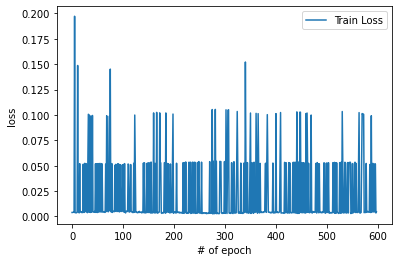

In [75]:
# training and testing
optimizer.zero_grad()           # clear gradients for this training step
train_losses = []
for epoch in range(EPOCH):
    running_loss = 0.0
    for i, (b_x, b_y) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader
        #print(b_x)
        b_x = Variable(b_x).type(torch.FloatTensor)
        b_y = b_y.type(torch.LongTensor)
        optimizer.zero_grad()           # clear gradients for this training step
        output = cnn(b_x)[0]            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        # print statistics
        running_loss += loss.item()
        train_losses.append(loss.item())
        if i % 10 == 0:    # print every 100 mini-batches
            #print(i)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
print('Finished Training')

# Let’s quickly save our trained model:
# Plot the training and test losses over time
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.xlabel("# of epoch")
plt.ylabel("loss")
plt.show()
!pwd
torch.save(cnn.state_dict(), "./content")


# apply the model to the test data

In [76]:
net = CNN()
net.load_state_dict(torch.load("./content"))
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, (b_x, b_y) in enumerate(test_loader):
        b_x = Variable(b_x).type(torch.FloatTensor)
        #print(b_x.shape)
        #b_y = b_y.type(torch.LongTensor)
        # calculate outputs by running the network
        outputs = net(b_x)
        #print(outputs[0].shape)
        #print(outputs[1].shape)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs[0], 1)
        total += b_y.size(0)
        correct += (predicted == b_y).sum().item()           

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 99 %
